На первом шаге устанавливаем и обновляем дополнительные модули. После этого требуется сделать рестарт рантайма, т.к. изначальная версия pandas старая, и могут быть ошибки импорта подготовленного датафрейма.

In [0]:
!pip install -U -q pytils pandas keras_metrics
!pip install -q git+git://github.com/stared/livelossplot.git

    100% |████████████████████████████████| 92kB 7.2MB/s 
    100% |████████████████████████████████| 10.1MB 3.2MB/s 
fastai 0.7.0 has requirement torch<0.4, but you'll have torch 1.0.1.post2 which is incompatible.
pymc3 3.6 has requirement joblib<0.13.0, but you'll have joblib 0.13.2 which is incompatible.


Монтируем Google Drive, оттуда будем загружать исходные данные и сохранять туда всю нашу работу

In [0]:
!apt-get update -qq 2>&1 > /dev/null
!apt-get install -y -qq software-properties-common module-init-tools  > /dev/null
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse > /dev/null
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

# mount gdrive
#!umount /gdrive

!mkdir -p /gdrive
!google-drive-ocamlfuse /gdrive


In [0]:
!mkdir -p /dnn_data
#!cp /gdrive/dnn_data/dataframe_ver_6.pkl /dnn_data
!ls -la /gdrive/dnn_data

#working directory
!mkdir -p /gdrive/dnn_data/ansamble_w2v
work_dir='/gdrive/dnn_data/ansamble_w2v'


total 2478920
drwxr-xr-x 2 root root       4096 Dec 24 09:46 .
drwxr-xr-x 2 root root       4096 Feb 21 07:38 ..
drwxr-xr-x 2 root root       4096 Jan 21 10:22 ansamble
drwxr-xr-x 2 root root       4096 Feb  8 09:55 ansamble_w2v
drwxr-xr-x 2 root root       4096 Feb 21 08:08 ansamble_w2v_latest
-rw-r--r-- 1 root root      29875 Feb 19 18:06 comments_test.txt
-rw-r--r-- 1 root root   38432307 Feb 11 11:11 dataframe_ver_5.pkl
-rw-r--r-- 1 root root   34615192 Feb 17 13:15 dataframe_ver_6.pkl
-rw-r--r-- 1 root root 1709510144 Jan 18 12:32 dnn-train.tar
-rw-r--r-- 1 root root  755800447 Feb 14 07:39 model_cbow_300_i50_w5_n10.vec
drwxr-xr-x 2 root root       4096 Jan  9 01:09 train


Импортируем модули, определяем пачку регулярных выражений для очистки текста от лишнего мусора. Для разбора на предложения используем стандартный токенизатор sent_tokenize с загруженными русскими правилами. Данный блок повторяет функции из export_clean_dataframe.py Функция clean_text_post поддерживает перевод транслита в кириллицу, это необходимо т.к. корпус данных содержит значительный объем таких строк.

In [0]:
from livelossplot.keras import PlotLossesCallback
import os
import sys
import gc
import re
import numpy as np
import math
import pytils
import pandas as pd
import string
import keras
import keras_metrics
import matplotlib.pyplot as plt
from tensorflow import set_random_seed
from pymystem3 import Mystem
from keras import layers,regularizers
from keras.models import Sequential, model_from_json, Model, Input
from keras.utils import np_utils, plot_model
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing import sequence
from keras.layers.core import Dense, Dropout, Activation, SpatialDropout1D
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM, GRU
from keras.layers.convolutional import Convolution1D, MaxPooling1D
from keras.layers.normalization import BatchNormalization
from keras.layers import CuDNNGRU as GRUgpu, TimeDistributed, RepeatVector, Permute, Lambda
from keras.layers import Conv1D, GlobalMaxPooling1D, Flatten, concatenate, average, merge, multiply, Reshape, LeakyReLU, Bidirectional
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, TensorBoard, LearningRateScheduler, ReduceLROnPlateau
from keras import backend as K
from sklearn.metrics import roc_curve, auc, confusion_matrix, precision_recall_curve, average_precision_score, classification_report, f1_score
from sklearn.utils.fixes import signature
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

#reload(sys)
#sys.setdefaultencoding('utf-8')

#REGEXPS
re0  = re.compile(ur'[:;_—.,!?©*@#$%^&()`\']|[+=]|[[]|[]]|[/]|"|\s{2,}|\-{2,}|\n')
re2 = re.compile(r'<.+?>') # HTML tags
re4 = re.compile(r"((www\.[^\s]+)|(https?://[^\s]+))") #URLs
re6 = re.compile(r'([' + string.punctuation + ']){1,}') # punctuation
re8 = re.compile(ur"(\S+)-{0,}\b", re.UNICODE) # word-
re10 = re.compile(ur"([^0-9]+?)4([^0-9]+?)\b", re.UNICODE) #word4word
re12 = re.compile(ur"\B-{1,}(\S+)\b", re.UNICODE) #-word
re14 = re.compile(r'\s\d{5,}?\s') #deleting digits 5 or more
re16 = re.compile(ur"((дата:\s\d{2}\.\d{2}.\d{4}\s\d{2}:\d{2}:\d{2})|(оценка:\s\d{1,2})|(отправить\sсообщение)|(автор:\s(.+?)\s))", re.UNICODE) # dates\scores
re18 = re.compile(ur"\b4(\w+?)\b", re.UNICODE) #4word
re20 = re.compile(ur"([а-жзк-мор-я])\1{2,}", re.UNICODE) #wooorrd -> word
re22 = re.compile(ur"([а-я])\1{2,}", re.UNICODE) #wooorrd -> word
re24 = re.compile(r'-(.)\s') #word-x\s -> word x
re26 = re.compile(r'\s{1,}-\s{1,}') # " one - two " -> "one-two"
re28 = re.compile(ur'(\S{4,}?)\s{0,}-\s{0,}(\S{3,}.?)')
re30 = re.compile(r'\s{1,}-(\S+?)\s')
re32 = re.compile(ur'\s{1,}(\S{1,2})-(\S|\D+?)\s') # " to-any " -> "any"
re34 = re.compile(ur"\b([a-zа-я]+?)\d\b",re.UNICODE) # word1 -> word 1
re36 = re.compile(ur"(?:\b(\w{1,2})-(.+?)\b)",re.UNICODE)   #to-word ->  to word
re38 = re.compile(ur"(?:\b([a-zа-я]{5,})-(.+?)\b)",re.UNICODE) #abcdef-word -> abcdef word
re40 = re.compile(ur"\b(цитата)(.+?)\b",re.UNICODE) #quoteword -> quote word
reUSP = re.compile(r"\r|\n|\t|\x0b|\x0c|\x1c|\x1d|\x1e|\x1f|\s|\x85|\xa0|\u1680|\u180e|\u2000|\u2001|\u2002|\u2003|\u2004|\u2005|\u2006|\u2007|\u2008|\u2009|\u200a|\u2028|\u2029|\u202f|\u205f|\u3000|\xe2|\u2800") #unicode spaces
reSP = re.compile(r'\s{2,}') #spaces
reEN = re.compile(r'[a-z]')
reENW = re.compile(r'\b([a-z]{2,}).*?\b') #words
reEML = re.compile(r"([a-z0-9!#$%&'*+/=?^_`{|}~-]+(?:\.[a-z0-9!#$%&'*+/=?^_`{|}~-]+)*@(?:[a-z0-9](?:[a-z0-9-]*[a-z0-9])?\.)+[a-z0-9](?:[a-z0-9-]*[a-z0-9])?)") #email

def clean_text_pre(text):
    text = text.lower()
    text = text.replace("\\"," ").replace("&quot;"," ").replace("&nbsp;"," ").replace("&gt;"," ").replace("&lt;"," ").replace("&amp;"," ").replace("\"r"," ").replace("\"n"," ").replace(u'—','-').replace(u'…','.')
    text = text.replace(u'№', ' ').replace(u'«',' ').replace(u'»',' ').replace('[quote]',' ').replace('[/quote]',' ')
    text = re2.sub(' ', text)
    text = re4.sub(' URL ', text)
    text = reEML.sub(r' MAIL ', text)
    text = re6.sub(r'\1', text)
    text = re8.sub(r' \1 ', text)
    text = re10.sub(ur' \1ч\2 ', text)
    text = re12.sub(r' \1 ', text)
    text = re14.sub(' ', text)
    text = re16.sub(' ', text)
    text = re18.sub(ur' ч\1 ', text)
    text = re20.sub(r'\1', text)
    text = re22.sub(r'\1', text)
    text = re24.sub(r' \1 ', text)
    text = re26.sub('-', text)
    text = re28.sub(r'\1 \2', text)
    text = re30.sub(r'-\1', text)
    text = re32.sub(r' \1 ', text)
    text = re34.sub(r' \1 ', text)
    text = re36.sub(ur' \1 \2 ', text)
    text = re38.sub(ur' \1 \2 ', text)
    text = re40.sub(ur' \1 \2 ', text)
    text = reENW.sub(r' \1 ', text)
    return text

def clean_text_post(text, tils_enable=True):
    text = re0.sub(' ', text)
    if tils_enable:
        # разрешаем транслитерацию, при дополнительном условии наличия в строке английских символов
        if reEN.search(text):
             text = pytils.translit.detranslify(text)
             text = text.replace("w",u'в')
    text = text.decode("utf-8")
    text = reUSP.sub(' ', text)
    text = reSP.sub(' ', text)
    return text

def tokenize_ru(text):
    tokens = word_tokenize(text)
    tokens = [i for i in tokens if (i not in string.punctuation)]
    return tokens

def clean_text(text):
    txt = [tokenize_ru(sent) for sent in sent_tokenize(clean_text_pre(text), 'russian')]
    txt = clean_text_post(" ".join(sum(txt, [])))
    return txt


print "Init done"

Using TensorFlow backend.


Init done


In [0]:
# load dataframe and get train data
df = pd.read_pickle('/gdrive/dnn_data/dataframe_ver_6.pkl')
print df['comment'].tail(10)
descriptions = df['comment'].tolist()
categories = df['category'].values
del df

Преобразуем текст в последовательности чисел, формируем обучающую и валидационную выборки. 

Ввиду специфики моего корпуса данных на валидацию выбираем  определенную часть: начальную, финальную, случайное равномерное распределение. От правильности выбора зависит точность обучения и крайне желательно иметь отдельную тестовую выборку, которая будет использоваться в последующей оценке обученной модели.  В общем случае лучше воспользоваться функцией train_test_split из sklearn, а не изобретать свои велосипеды.

При дополнении последовательностей нужно подобрать правильный padding, на моих данных различия между post и pre составляют несколько процентов финальной точности модели.

In [0]:
GLOBAL_SEED = 12345

#### стандартный токенайзер
# создаем единый словарь (слово -> число)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(descriptions)

# Преобразуем все строки в числовые последовательности, заменяя слова на числа по словарю.
textSequences = tokenizer.texts_to_sequences(descriptions)

# Разделяем датасет на тренировочную и тестовые выборки. Каждая функция берет тест с начала или с конца датасета.
def load_data_from_arrays_test_last(strings, labels, train_test_split=0.9):
    data_size = len(strings)
    test_size = int(data_size - round(data_size * train_test_split))
    #print("Test size: {}".format(test_size))
    #print("Test offset: {}".format(data_size - test_size))
    
    print("\nTraining set:")
    x_train = strings[:(data_size - test_size)]
    print("\t - x_train: {}".format(len(x_train)))
    y_train = labels[:(data_size - test_size)]
    print("\t - y_train: {}".format(len(y_train)))
    
    print("\nTesting set:")
    x_test = strings[(data_size - test_size):]
    print("\t - x_test: {}".format(len(x_test)))
    y_test = labels[(data_size - test_size):]
    print("\t - y_test: {}".format(len(y_test)))
    return x_train, y_train, x_test, y_test
  
def load_data_from_arrays_test_first(strings, labels, train_test_split=0.9):
    data_size = len(strings)
    test_size = int(data_size - round(data_size * train_test_split))
    #print("Test size: {}".format(test_size))
    
    print("\nTraining set:")
    x_train = strings[test_size:]
    print("\t - x_train: {}".format(len(x_train)))
    y_train = labels[test_size:]
    print("\t - y_train: {}".format(len(y_train)))
    
    print("\nTesting set:")
    x_test = strings[:test_size]
    print("\t - x_test: {}".format(len(x_test)))
    y_test = labels[:test_size]
    print("\t - y_test: {}".format(len(y_test)))
    return x_train, y_train, x_test, y_test

np.random.seed(GLOBAL_SEED) # фиксируем выборку

# случайная выборка из всего датасета, сбалансированная по классам
def load_data_from_arrays_random(strings, labels, train_test_split=0.8):
    def shuffle_full_dataset(strings, labels):
        idx = np.where(labels < 2 )[0]
        np.random.shuffle(idx)
        
        return np.asarray(strings)[idx].tolist(), labels[idx]
    
    strings, labels = shuffle_full_dataset(strings, labels)
    
    import collections
    print "Dataset distribution:", collections.Counter(labels)

    data_size = len(strings)
    test_size = int(data_size - round(data_size * train_test_split)) / 2
    data = np.asarray(strings)
    
    idx_one = np.where(labels == 1)[0]
    idx_zero = np.where(labels == 0)[0]
    #idx_one[0].size

    # random select test data
    rnd_one = np.random.choice(idx_one, test_size, replace=False)
    rnd_zero = np.random.choice(idx_zero, test_size, replace=False)
    
    idx_test = np.hstack((rnd_one, rnd_zero))
    np.random.shuffle(idx_test)
    
    x_test = data[idx_test].tolist()
    y_test = labels[idx_test]
    print "Test distribution:", collections.Counter(y_test)
    
    # remove our test from oridinal data
    data = np.delete(data, idx_test).tolist()
    labels = np.delete(labels, idx_test)
    
    print("\nTraining set:")
    print("\t - x_train: {}".format(len(data)))
    print("\t - y_train: {}".format(len(labels)))
    
    print("\nTesting set:")
    print("\t - x_test: {}".format(len(x_test)))
    print("\t - y_test: {}".format(len(y_test)))
    
    return data, labels, x_test, y_test

X_train, y_train, X_test, y_test = load_data_from_arrays_random(textSequences, categories, train_test_split=0.8) 

# Максимальное количество слов в самом длинном описании
max_words = 0
for desc in descriptions:
    words = len(desc.split())
    if words > max_words:
        max_words = words

total_unique_words = len(tokenizer.word_index)+1
# максимальное количество слов для анализа
max_features = total_unique_words
maxSequenceLength = max_words

print(u'Максимальное количество слов в самом длинном тексте: {} слов'.format(max_words))
print(u'Всего уникальных слов в словаре: {}'.format(total_unique_words))

#Дополняем вектора до полной длинны
X_train = sequence.pad_sequences(X_train, maxlen=maxSequenceLength, padding='post')
X_test = sequence.pad_sequences(X_test, maxlen=maxSequenceLength, padding='post')
print('Dimension X_train:', X_train.shape)
print('Dimension X_test:', X_test.shape)
##################################################################

#del descriptions
#del categories
r = gc.collect()


Dataset distribution: Counter({1: 107129, 0: 106965})
Test distribution: Counter({0: 21409, 1: 21409})

Training set:
	 - x_train: 171276
	 - y_train: 171276

Testing set:
	 - x_test: 42818
	 - y_test: 42818
Максимальное количество слов в самом длинном тексте: 84 слов
Всего уникальных слов в словаре: 92275
('Dimension X_train:', (171276, 84))
('Dimension X_test:', (42818, 84))


Загружаем вектора из предварительно обученной на нашем корпусе данных модели FastText.
В данном случае используется модель cbow, размерность вектора 300, окно 5 слов, 10 негативных примеров, 50 итераций обучения

In [0]:
# FastText Load model & build embed matrix
from numpy import asarray
from numpy import zeros
from tqdm import tqdm

# Загрузка файла с векторами слов в память
embeddings_index = dict()
DIM = 300
f = open('/gdrive/dnn_data/model_cbow_300_i50_w5_n10.vec')
for line in tqdm(f):
	values = line.rstrip().rsplit(' ')
	word = values[0].decode("utf-8")
	coefs = asarray(values[1:], dtype='float32')
	embeddings_index[word] = coefs
f.close()
words_not_found = []
print(u'Загружено %s векторов для слов' % len(embeddings_index))

embedding_matrix = np.zeros((total_unique_words, DIM))
#embedding_matrix = np.random.random((total_unique_words, DIM)) #альтернативный вариант инициализации весов.
word_voc = 0
# Добавляем наиболее часто встречающихся слова из словаря токенайзера в embedding слой
for word, i in tokenizer.word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector
    word_voc += 1
  else:
    words_not_found.append(word)
print u"Всего слов в матрице: ", word_voc
print(u'Количество пустых векторов: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

del embeddings_index

307153it [00:32, 9564.24it/s] 


Загружено 307153 векторов для слов
Всего слов в матрице:  71579
Количество пустых векторов: 20696


In [0]:
print(u"Пример слов не попавших в матрицу: %s " % " ".join(np.random.choice(words_not_found, 10)))

Пример слов не попавших в матрицу: хайвея отниат cоралл сттихоплет разновкусие лордика алс–с1 зяблика односайчане выствления 


In [0]:
# Вспомогательные функции, компиляция модели, отображения графиков, построения матрицы ошибок

class LearningRateMonitor(Callback):
  # start of training
  def on_train_begin(self, logs={}):
      self.lrates = list()
      #self.lr = float(K.get_value(self.model.optimizer.lr))
  
  # end of each training epoch
  def on_epoch_end(self, epoch, logs={}):
		# get and store the learning rate
		optimizer = self.model.optimizer
		lrate = float(K.get_value(self.model.optimizer.lr))
		self.lrates.append(lrate)
    
def compile_and_train(model, num_epochs, tblog=0, estop=1, a_lr = 2, initial_lrate=0.005):
    """
    Компиляция модели и запуск тренировки. 
    :param model: Модель keras
    :type model: Sequential
    :param num_epochs: Число эпох обучения
    :type num_epochs: int
    :param tblog: Разрешает сохранение лог файлов для tensorboard
    :type tblog: int
    :param estop: Включает(по умолчанию) режим EarlyStopping. При включенном режиме лучшие веса восстанавливаются автоматически
    :type estop: int
    :param a_lr:  Выбор варианта применения адаптивного learning rate, 0 - выключено, 1 - пользовательская функция, 2 - экспоненциальное уменьшение(по умолчанию), 3 - скачкообразное уменьшение при наличии плато
    :type a_lr: int
    :param initial_lrate: Начальный learning rate
    :type initial_lrate: float
    """
    w_dir=work_dir + '/weights'
    if not os.path.exists(w_dir):
        os.makedirs(w_dir)
    
    # Параметры для создания контрольных точек
    # val_loss val_f1_score val_acc val_precision val_recall
    mon_param = 'val_loss'
    # min, max, auto
    mon_mode = 'min'
    filepath = w_dir + '/' + model.name + '.{epoch:02d}-{loss:.4f}-{acc:.4f}-{val_loss:.4f}-{val_acc:.4f}.hdf5'
    checkpoint = ModelCheckpoint(filepath, monitor=mon_param, verbose=0, save_weights_only=True, save_best_only=True, mode=mon_mode, period=1)
    
    tensor_board = TensorBoard(log_dir=work_dir+'tf-logs/', histogram_freq=0, batch_size=batch_size)
    early_stopping = EarlyStopping(monitor=mon_param, min_delta=0.0001, patience=10, restore_best_weights=True)
    adam=keras.optimizers.Adam(lr=initial_lrate, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    cb = [checkpoint, PlotLossesCallback()]
    if tblog == 1:
        if not os.path.exists(work_dir + 'tf-logs/'):
            os.makedirs(work_dir + 'tf-logs/')
        cb.append(tensor_board)
    if estop == 1:
        cb.append(early_stopping)
    if a_lr == 1:
        # adaptive learning rate step schedule
        def step_decay(epoch):
            drop = 0.5
            epochs_drop = 2.0
            lrate = initial_lrate * math.pow(drop, math.floor((1 + epoch) / epochs_drop))
            return lrate
        # learning schedule callback
        lrate = LearningRateScheduler(step_decay)
        cb.append(lrate)
    elif a_lr == 2:
        # adaptive learning rate exponential
        adam=keras.optimizers.Adam(lr=initial_lrate, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.05)
    elif a_lr == 3:
        # drop LR  by lr = lr * factor
        rlrop = ReduceLROnPlateau(monitor=mon_param, mode=mon_mode, min_delta=0.01, factor=0.2, patience=3)
        lrm = LearningRateMonitor()
        cb.append(rlrop)
        cb.append(lrm)
        
    print model.name
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy', keras_metrics.precision(), keras_metrics.recall(), keras_metrics.f1_score()]) 
    history = model.fit(x=X_train, y=y_train, 
                    batch_size=batch_size,
                    epochs=num_epochs, verbose=1,
                    callbacks=cb,
                    validation_data=(X_test, y_test)
    )
    return history, lrm

def ensembleModels(models, model_input, name='ensemble'):
    # collect outputs of models in a list
    yModels=[model(model_input) for model in models] 
    # averaging outputs
    yAvg=layers.average(yModels) 
    # build model from same input and avg output
    modelEns = Model(inputs=model_input, outputs=yAvg, name=name)  
   
    return modelEns

def evaluate_error_on_test(model):
    pred = model.predict(X_test, batch_size = batch_size)
    pred = np.argmax(pred, axis=1)
    pred = np.expand_dims(pred, axis=1) # make same shape as y_test
    error = np.sum(np.not_equal(pred, np.expand_dims(y_test, axis=1))) / y_test.shape[0]
    return error

def score_model(model, th = 0):
    score = model.evaluate(X_test, y_test,
                       batch_size=batch_size, verbose=0)
    print(model.name)
    print(u'Ошибка теста: {}'.format(score[0]))
    print(u'Оценка точности модели: {}'.format(score[1]*100))
    if th > 0:
       print classification_report(y_test, model_predict_test_th(model, th), target_names=['Not author', 'Author'])
    
    return score
    
def save_model(model):
    model_json = model.to_json()
    json_file = open(work_dir + '/' + model.name + ".json", "w")
    json_file.write(model_json)
    json_file.close()
    model.save_weights(work_dir + '/' + model.name + ".hdf5")
    print ("Done")

def restore_model(name):
    # Загружаем данные об архитектуре сети из файла json
    json_file = open(work_dir + '/' + name+".json", "r")
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    model.load_weights(work_dir + '/' + name+".hdf5")
    adam=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    print (model.summary())
    return model

def get_weight_file(model_name, epoch):
  """
    Выбор файла с весами для определенной эпохи
  """
  from pathlib import Path
  pathlist = Path(work_dir + '/weights/').glob(model_name + '.' + str(epoch) + '-*')
  for path in pathlist:
      return str(path)

def get_best_weight_file(model_name):
  """
    Автоматический выбор файла весов с минимальным параметром потерь и максимальной точностью
  """
  from pathlib import Path
  pathlist = Path(work_dir + '/weights/').glob(model_name + '*')
  data = []
  for path in pathlist:
      d = str(path).split('-')
      d[4] = d[4].replace('.hdf5','')
      data.append(d)
  ret = ''
  if len(data) > 0:
    a = np.array(data)
    a=a[np.lexsort((a[:,4], a[:,3]))][::1] 
    ret = "-".join(a[0]) + ".hdf5"
    print "Load weight: " + ret
  return ret

def compile_models(models):
  adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
  for model in models:
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
  print "Done compilling"

def sequence_to_text(seq):
    """
      Обратное преобразование последовательности в строку
    """
    reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))
    def sequence_to_words(list_of_indices):
        # Looking up words in dictionary
        words = [reverse_word_map.get(letter) for letter in list_of_indices if letter != 0]
        return(words)
    ret_txt = map(sequence_to_words, [seq])
    return " ".join(ret_txt[0])

def build_cf_matrix(model, threshold=0.9):
    """
      Собираем матрицу на основе валидационной выборки
    """
    y_pred = model.predict(X_test)
    y_pred = y_pred.flatten()
    y_pred = y_pred >= threshold
    return confusion_matrix(y_test, y_pred)

def model_predict_test_th(model, threshold=0.5):
    """
      Приводим валидационную выборку к класса по пороговому значению
    """
    y_pred = model.predict(X_test)
    y_pred = y_pred.flatten()
    y_pred = y_pred >= threshold
    return y_pred

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

def draw_model_history(historys, model_name="", N=0):
    import matplotlib
    import matplotlib.pyplot as plt
    plt.style.use("ggplot")
    plt.figure()
    i = 1
    for h in historys:
      if N > 0:
        plt.plot(np.arange(0, N), h.history["loss"], label="train_loss" + str(i))
        plt.plot(np.arange(0, N), h.history["val_loss"], label="val_loss" + str(i))
        plt.plot(np.arange(0, N), h.history["acc"], label="train_acc" + str(i))
        plt.plot(np.arange(0, N), h.history["val_acc"], label="val_acc" + str(i))
      else:
        plt.plot(h.history["loss"], label="train_loss" + str(i))
        plt.plot(h.history["val_loss"], label="val_loss" + str(i))
        plt.plot(h.history["acc"], label="train_acc" + str(i))
        plt.plot(h.history["val_acc"], label="val_acc" + str(i))
        
      i = i +1
    
    plt.title(u"Эффективность обучения " + model_name)
    plt.xlabel(u"Повторения #")
    plt.ylabel(u"Ошибки")
    plt.legend(loc="lower left")
    plt.show()

def draw_roc_curve(model):
  y_pred_keras = model.predict(X_test).ravel()
  fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)
  auc_keras = auc(fpr_keras, tpr_keras)
  plt.figure()
  plt.plot(fpr_keras,tpr_keras,label='area = %.3f' %auc_keras)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.title('ROC curve ' + model.name)
  plt.legend(loc='best')
  plt.show()

def draw_prec_recall_curve(model):
    y_pred = model.predict(X_test)
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    average_precision = average_precision_score(y_test, y_pred)
    step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})
    plt.figure()
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title(model.name + ' Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
    plt.show()

def draw_f_curve(model):
    """
    Отображение F-кривой в зависимости от порога, возвращает наилучшее пороговое значение классификатора
    """
    y_pred = model.predict(X_test)
    y_pred = y_pred.flatten()
    thresholds = np.linspace(0, 1, 100)
    scores = [f1_score(y_test, (y_pred > t).astype(np.int)) for t in thresholds]
    plt.figure()
    plt.plot(thresholds, scores, label='F-score (' + str(round( np.max(scores), 4)) + ')')
    plt.scatter(thresholds[np.argmax(scores)], np.max(scores), label='Maximum (' + str(round(thresholds[np.argmax(scores)], 4))+")")
    plt.legend(); plt.xlabel('Threshold'); plt.ylabel('F-score')
    plt.title('F-score for balanced dataset')
    plt.show()
    return thresholds[np.argmax(scores)]

def draw_lr_drops(series, title):
	#plt.subplot(220)
  plt.title(title)
	plt.plot(series)
	plt.title('LR DROP', pad=-80)
	plt.show()
  
  
print "Utils OK"

Utils OK


In [0]:
# Наши тестовые модели

def model_attention(conn_layer, reduce_dim = False):
    # compute importance for each step
    attention = TimeDistributed(Dense(1, activation='elu'), name='A_TimeDistributed')(conn_layer)
    attention = Flatten(name='A_Flatten')(attention)
    attention = Activation('softmax', name='A_Activation')(attention)
    attention = RepeatVector(K.int_shape(conn_layer)[2], name='A_RepeatVector')(attention)
    attention = Permute([2, 1], name='A_Permute')(attention)
    # apply the attention
    sent_representation = multiply([conn_layer, attention], name='A_Multiply')
    if reduce_dim:
       return Lambda(lambda xin: K.sum(xin, axis=1),name='A_Lambda')(sent_representation)
    else:
       return sent_representation
    
def model_conv_core(model_input):
    num_filters = 128
    X = Embedding(total_unique_words, DIM, input_length=max_words, weights=[embedding_matrix], trainable=False, name='Word2Vec')(model_input)
    X = Conv1D(num_filters, 3, activation='relu', padding='same')(X)
    X = Dropout(0.3)(X)
    X = MaxPooling1D(2)(X)    
    X = Conv1D(num_filters, 5, activation='relu', padding='same')(X)    
    return X

  
def model_conv1d(model_input, num_filters=64, kernel_size=3, attention=True):
    X = Embedding(total_unique_words, DIM, input_length=max_words, weights=[embedding_matrix], trainable=False, name='Word2Vec')(model_input)
    X = Conv1D(num_filters, kernel_size, padding='same', activation='relu', strides=1)(X)
    X = MaxPooling1D(pool_size=2)(X)
    if attention:
       X = model_attention(X)
    X = LSTM(256, kernel_regularizer=regularizers.l2(0.004))(X)
    X = Dropout(0.3)(X)
    X = Dense(128, kernel_regularizer=regularizers.l2(0.0004))(X)
    X = LeakyReLU()(X)
    X = BatchNormalization()(X)
    X = Dense(1, activation="sigmoid")(X)
    model = Model(model_input, X, name='w2v_conv1d')
    return model
  
def model_gru(model_input, attention=True):
    X = model_conv_core(model_input)
    X = MaxPooling1D(2)(X)
    X = Dropout(0.2)(X)
    X = GRUgpu(256, return_sequences=True, kernel_regularizer=regularizers.l2(0.004))(X)
    X = LeakyReLU()(X)
    if attention:
       X = model_attention(X)
    X = Dropout(0.2)(X)
    X = GRUgpu(128, kernel_regularizer=regularizers.l2(0.0004))(X)
    X = LeakyReLU()(X)
    X = Dropout(0.1)(X)
    X = BatchNormalization()(X)
    X = Dense(1, activation="sigmoid")(X)
    model = Model(model_input, X, name='w2v_gru')
    return model

def model_cnn(model_input, embd_size = 128, attention=True):
    X = model_conv_core(model_input)
    if attention:
       X = model_attention(X, True)
    else:
       X = GlobalMaxPooling1D()(X)
    X = Dense(int(round(embd_size / 2.0)), activation='relu')(X)
    X = Dropout(0.3)(X)
    X = Dense(int(round(embd_size / 3.0)), activation='relu')(X)
    X = Dropout(0.2)(X)
    X = Dense(int(round(embd_size / 4.0)), activation='relu', kernel_regularizer=regularizers.l2(0.0004))(X)
    X = BatchNormalization()(X)
    X = Dense(1, activation='sigmoid')(X)
    model = Model(model_input, X, name='w2v_cnn')
    return model

def model_lstm_cnn(model_input, attention=True):
    X = model_conv_core(model_input)
    X = MaxPooling1D(2)(X)
    X = LSTM(256, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, kernel_regularizer=regularizers.l2(0.0004))(X)
    X = LeakyReLU()(X)
    if attention:
       X = model_attention(X)
    X = Flatten()(X)
    X = Dropout(0.3)(X)
    X = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0004))(X)
    X = BatchNormalization()(X)
    X = Dense(1, activation="sigmoid")(X)
    model = Model(model_input, X, name='w2v_lstm_cnn')
    return model

def model_cnn_filters(model_input, attention=True):
    branches = []
    X = Embedding(total_unique_words, DIM, input_length=max_words, weights=[embedding_matrix], trainable=False, name='Word2Vec')(model_input)
    for size, filters_count in [(3, 75), (3, 150), (5, 75), (5, 150), (7, 75), (7, 150)]:
        branch = Conv1D(filters=filters_count, kernel_size=size, padding='same', activation='elu', strides=1, name='conv1d_'+str(size)+'_'+str(filters_count))(X)
        if K.int_shape(branch)[2] < 150:
           branch =concatenate([branch,branch])
        #branch = GlobalMaxPooling1D()(branch)
        branches.append(branch)
    
    X = concatenate(branches, axis=1)
    if attention:
       X = model_attention(X, True)
    X = Dense(384, activation='relu', kernel_regularizer=regularizers.l2(0.004))(X)
    X = Dropout(0.3)(X)
    # X = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.004))(X)
    X = BatchNormalization()(X)
    X = Dense(1, activation="sigmoid")(X)
    model = Model(model_input, X, name='w2v_cnn_filters')
    return model

def model_conv2d(model_input, embd_size = 128, attention=True):
    from keras.layers import MaxPool2D, Conv2D, Reshape
    num_filters = 256
    filter_sizes = [3, 5, 7]
    X = Embedding(total_unique_words, DIM, input_length=max_words, weights=[embedding_matrix], trainable=False, name='Word2Vec')(model_input)
    reshape = Reshape((maxSequenceLength, embd_size, 1))(X)
    conv_0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], embd_size), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
    conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[1], embd_size), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
    conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[2], embd_size), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
    maxpool_0 = MaxPool2D(pool_size=(maxSequenceLength - filter_sizes[0] + 1, 1), strides=(1,1), padding='valid')(conv_0)
    maxpool_1 = MaxPool2D(pool_size=(maxSequenceLength - filter_sizes[1] + 1, 1), strides=(1,1), padding='valid')(conv_1)
    maxpool_2 = MaxPool2D(pool_size=(maxSequenceLength - filter_sizes[2] + 1, 1), strides=(1,1), padding='valid')(conv_2)
    X = concatenate([maxpool_0, maxpool_1, maxpool_2], axis=1)
    X = Dropout(0.2)(X)
    if attention:
       X = model_attention(X, True)    
    X = Flatten()(X)
    X = Dense(int(embd_size / 2.0), activation='relu', kernel_regularizer=regularizers.l2(0.004))(X)
    X = Dropout(0.5)(X)
    X = BatchNormalization()(X)
    X = Dense(1, activation="sigmoid")(X)
    model = Model(model_input, X, name='w2v_conv2d')
    return model

def model_lstm_bidir(model_input, attention=True):
    X = Embedding(total_unique_words, DIM, input_length=max_words, weights=[embedding_matrix], trainable=False, name='Word2Vec')(model_input)
    X = Bidirectional(LSTM(256, return_sequences=True, dropout=0.3, recurrent_dropout=0.2))(X)
    if attention:
       X = model_attention(X, True)
    else:
       X = GlobalMaxPooling1D()(X)
    X = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.004))(X)
    X = Dropout(0.5)(X)
    X = BatchNormalization()(X)
    X = Dense(1, activation="sigmoid")(X)
    model = Model(model_input, X, name='w2v_lstm_bidir')
    return model

def model_cnn_lstm_rnn(model_input, attention=True):
    X = model_conv_core(model_input)
    X = Dropout(0.2)(X)
    X = MaxPooling1D(2)(X)
    X = Bidirectional(LSTM(192, return_sequences=True, recurrent_dropout=0.3))(X)
    if attention:
       X = model_attention(X, True)
    X = Dropout(0.5)(X)
    X = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0004))(X)
    X = GlobalMaxPooling1D()(X)
    X = BatchNormalization()(X)
    X = Dense(1, activation="sigmoid")(X)
    model = Model(model_input, X, name='w2v_cnn_lstm_rnn')
    return model

def model_cnn_filters2(model_input, attention=True):
    branches = []
    X = Embedding(total_unique_words, DIM, input_length=max_words, weights=[embedding_matrix], trainable=False, name='Word2Vec')(model_input)
    branch = Conv1D(filters=128, kernel_size=7, padding='valid', activation='relu', strides=1, name='conv1d_'+str(7)+'_'+str(31))(X)
    branch = MaxPooling1D(3)(branch)
    branches.append(branch)
    branch = Conv1D(filters=128, kernel_size=7, padding='valid', activation='relu', strides=1, name='conv1d_'+str(7)+'_'+str(32))(X)
    branch = MaxPooling1D(3)(branch)
    branches.append(branch)
    branch = Conv1D(filters=128, kernel_size=5, padding='valid', activation='relu', strides=1, name='conv1d_'+str(5)+'_'+str(10))(X)
    branches.append(branch)
    branch = Conv1D(filters=128, kernel_size=5, padding='valid', activation='relu', strides=1, name='conv1d_'+str(5)+'_'+str(20))(X)
    branches.append(branch)
    branch = Conv1D(filters=128, kernel_size=3, padding='valid', activation='relu', strides=1, name='conv1d_'+str(3)+'_'+str(30))(X)
    branches.append(branch)
    branch = Conv1D(filters=128, kernel_size=3, padding='valid', activation='relu', strides=1, name='conv1d_'+str(3)+'_'+str(33))(X)
    branch = MaxPooling1D(3)(branch)
    branches.append(branch)
    X = concatenate(branches, axis=1)
    if attention:
       X = model_attention(X, True)
    else:
       X = GlobalMaxPooling1D()(X)
    X = Dropout(0.3)(X)
    X = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001))(X)
    X = Dropout(0.3)(X)
    X = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001))(X)
    X = Dropout(0.2)(X)
    X = BatchNormalization()(X)
    X = Dense(1, activation="sigmoid")(X)
    model = Model(model_input, X, name='w2v_cnn_filters2')
    return model


print "Models OK"

Models OK


In [0]:
#Set SEED
np.random.seed(GLOBAL_SEED)
set_random_seed(GLOBAL_SEED)

batch_size = 384
EP = 100 # Number of train epochs

# Определяем входной слой и собираем модели
model_input = Input(shape=X_train[0].shape, dtype='int32', name='MainInput')
model1 = model_conv1d(model_input)
model2 = model_gru(model_input)
model3 = model_cnn(model_input, DIM)
model4 = model_cnn_filters2(model_input)
model5 = model_lstm_cnn(model_input)
model6 = model_cnn_filters(model_input)
model7 = model_conv2d(model_input, DIM)
model8 = model_lstm_bidir(model_input)
model9 = model_cnn_lstm_rnn(model_input)

r = gc.collect()
print "Build OK"

Последовательная компиляция и тренировка каждой модели

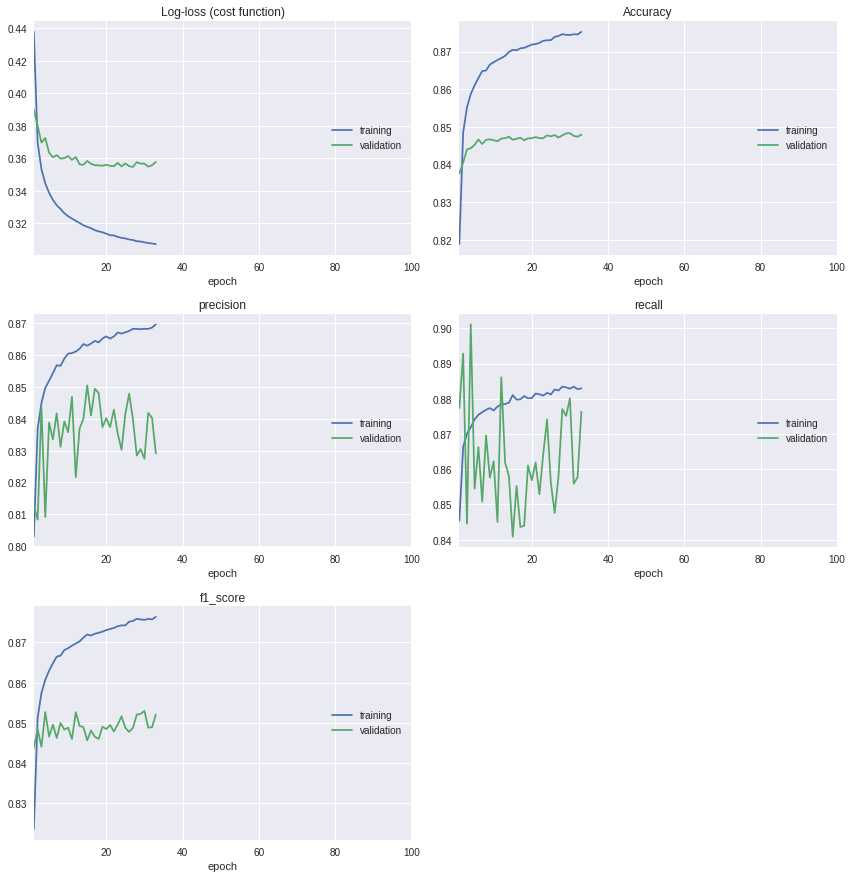

Log-loss (cost function):
training   (min:    0.307, max:    0.438, cur:    0.307)
validation (min:    0.355, max:    0.390, cur:    0.358)

Accuracy:
training   (min:    0.819, max:    0.875, cur:    0.875)
validation (min:    0.838, max:    0.848, cur:    0.848)

precision:
training   (min:    0.803, max:    0.870, cur:    0.870)
validation (min:    0.808, max:    0.851, cur:    0.829)

recall:
training   (min:    0.845, max:    0.883, cur:    0.883)
validation (min:    0.841, max:    0.901, cur:    0.876)

f1_score:
training   (min:    0.824, max:    0.876, cur:    0.876)
validation (min:    0.844, max:    0.853, cur:    0.852)
Epoch 34/100
118656/171276 [===================>..........] - ETA: 19s - loss: 0.3065 - acc: 0.8750 - precision: 0.8667 - recall: 0.8860 - f1_score: 0.8762

KeyboardInterrupt: ignored

In [0]:
history1, lrm1 = compile_and_train(model1, EP)
history2, lrm2 = compile_and_train(model2, EP)
history3, lrm3 = compile_and_train(model3, EP)
history4, lrm4 = compile_and_train(model4, EP)
history5, lrm5 = compile_and_train(model5, EP)
history6, lrm6 = compile_and_train(model6, EP)
history7, lrm7 = compile_and_train(model7, EP)
history8, lrm8 = compile_and_train(model8, EP)
history9, lrm9 = compile_and_train(model9, EP)

#draw_model_history([history1],model1.name)
#draw_model_history([history2],model2.name)
#draw_model_history([history3],model3.name)
#draw_model_history([history4],model4.name)
#draw_model_history([history5],model5.name)
#draw_model_history([history6],model6.name)
#draw_model_history([history7],model7.name)
#draw_model_history([history8],model8.name)
#draw_model_history([history9],model9.name)
draw_lr_drops(lrm1.lrates, model1.name)
draw_lr_drops(lrm2.lrates, model2.name)
draw_lr_drops(lrm3.lrates, model3.name)
draw_lr_drops(lrm4.lrates, model4.name)
draw_lr_drops(lrm5.lrates, model5.name)
draw_lr_drops(lrm6.lrates, model6.name)
draw_lr_drops(lrm7.lrates, model7.name)
draw_lr_drops(lrm8.lrates, model8.name)
draw_lr_drops(lrm9.lrates, model9.name)


In [0]:
# Загрузка лучших весов, исспользуется в основном только при перезапуске обучения, т.к. при включенном EarlyStopping лучшие веса восстанавливаются автоматически

model1.load_weights(get_best_weight_file(model1.name)) #conv1d
model2.load_weights(get_best_weight_file(model2.name)) #gru
model3.load_weights(get_best_weight_file(model3.name)) #cnn
model4.load_weights(get_best_weight_file(model4.name)) #cnn_filters2
model5.load_weights(get_best_weight_file(model5.name)) #lstm_cnn
model6.load_weights(get_best_weight_file(model6.name)) #cnn_filters
model7.load_weights(get_best_weight_file(model7.name)) #conv2d
model8.load_weights(get_best_weight_file(model8.name)) #lstm_bidir
model9.load_weights(get_best_weight_file(model9.name)) #cnn_lstm_rnn
compile_models([model1,model2,model3,model4,model5,model6,model7,model8,model9])

Load weight: /gdrive/dnn_data/ansamble_w2v/weights/w2v_conv1d.27-0.3096-0.8741-0.3546-0.8471.hdf5
Load weight: /gdrive/dnn_data/ansamble_w2v/weights/w2v_gru.99-0.3221-0.8633-0.3351-0.8520.hdf5
Load weight: /gdrive/dnn_data/ansamble_w2v/weights/w2v_cnn.96-0.3308-0.8612-0.3515-0.8498.hdf5
Load weight: /gdrive/dnn_data/ansamble_w2v/weights/w2v_cnn_filters2.98-0.3453-0.8627-0.3759-0.8448.hdf5
Load weight: /gdrive/dnn_data/ansamble_w2v/weights/w2v_lstm_cnn.98-0.3247-0.8641-0.3432-0.8526.hdf5
Load weight: /gdrive/dnn_data/ansamble_w2v/weights/w2v_cnn_filters.24-0.2998-0.8771-0.3578-0.8471.hdf5
Load weight: /gdrive/dnn_data/ansamble_w2v/weights/w2v_conv2d.42-0.2955-0.8785-0.3587-0.8465.hdf5
Load weight: /gdrive/dnn_data/ansamble_w2v/weights/w2v_lstm_bidir.41-0.3124-0.8693-0.3334-0.8586.hdf5
Load weight: /gdrive/dnn_data/ansamble_w2v/weights/w2v_cnn_lstm_rnn.100-0.3376-0.8610-0.3520-0.8529.hdf5
Done compilling


w2v_conv1d
Ошибка теста: 0.354606223665
Оценка точности модели: 84.7120369311
w2v_gru
Ошибка теста: 0.335102411306
Оценка точности модели: 85.2048202164
w2v_cnn
Ошибка теста: 0.351454984114
Оценка точности модели: 84.9829510692
w2v_cnn_filters2
Ошибка теста: 0.375865082557
Оценка точности модели: 84.4784903103
w2v_lstm_cnn
Ошибка теста: 0.343163164406
Оценка точности модели: 85.2585361082
w2v_cnn_filters
Ошибка теста: 0.357756192988
Оценка точности модели: 84.7143726481
w2v_conv2d
Ошибка теста: 0.358671656594
Оценка точности модели: 84.6489794463
w2v_lstm_bidir
Ошибка теста: 0.333354858757
Оценка точности модели: 85.8634217614
w2v_cnn_lstm_rnn
Ошибка теста: 0.351969624657
Оценка точности модели: 85.2865616473


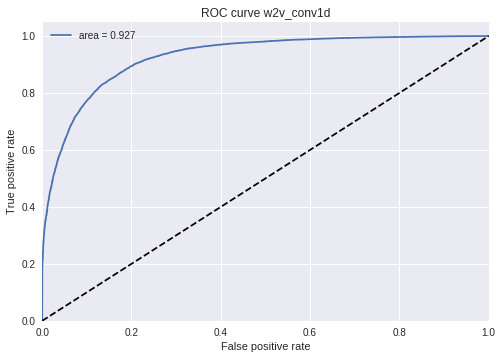

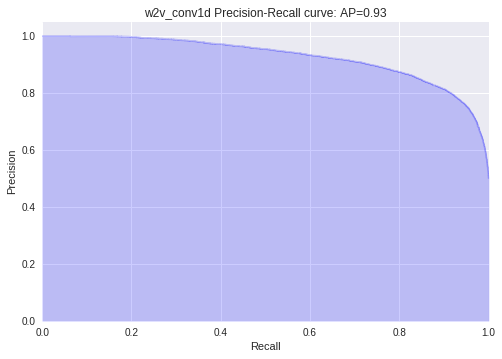

/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


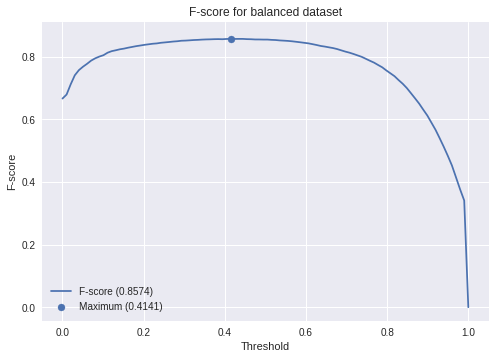

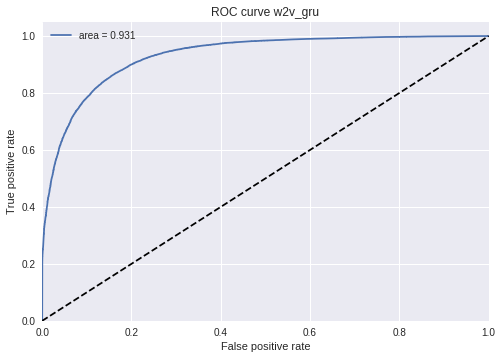

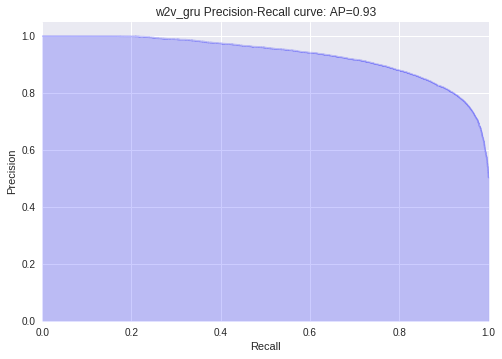

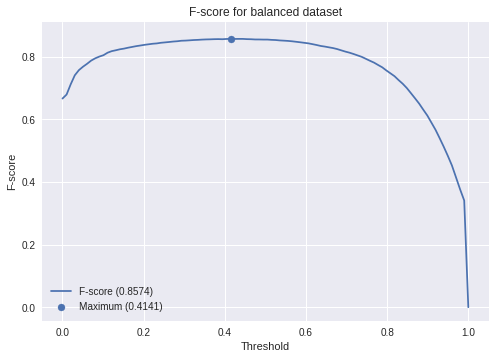

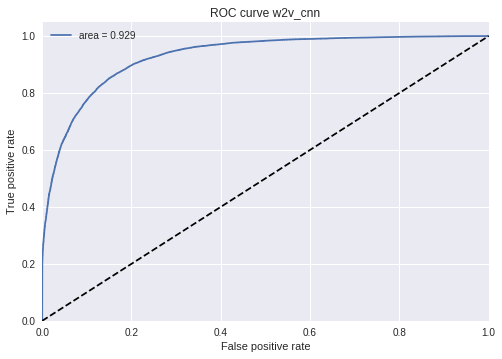

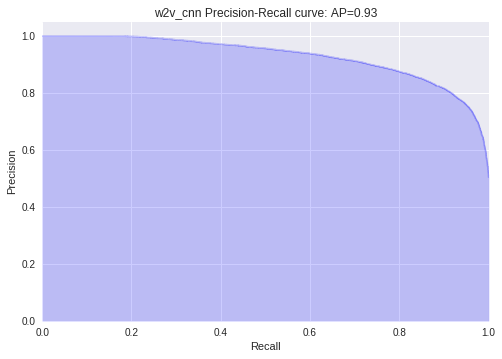

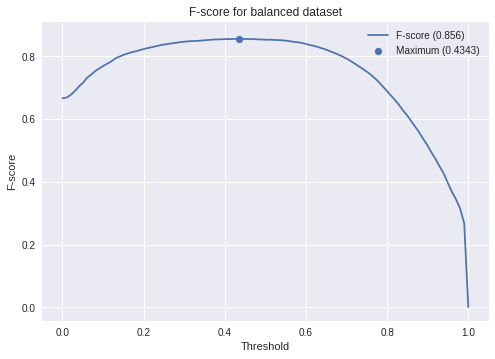

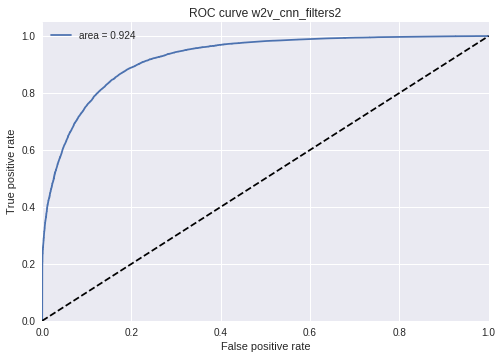

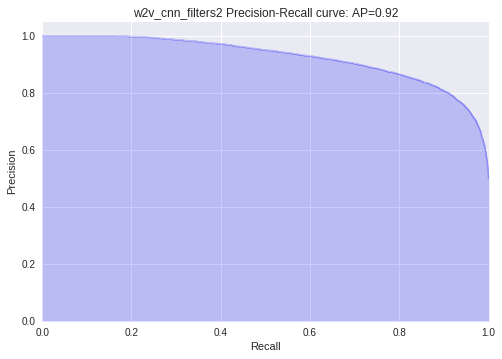

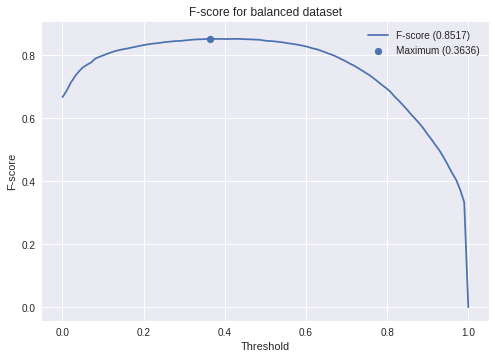

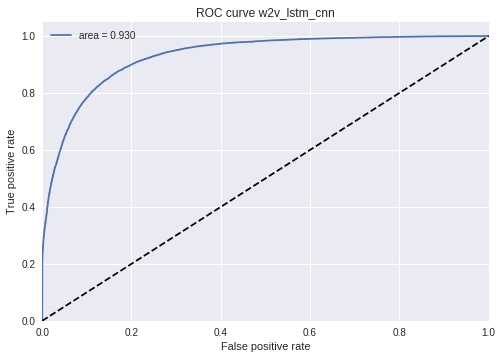

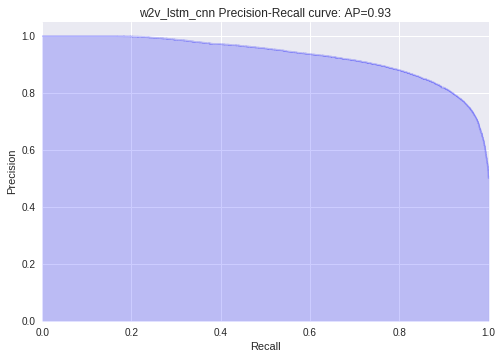

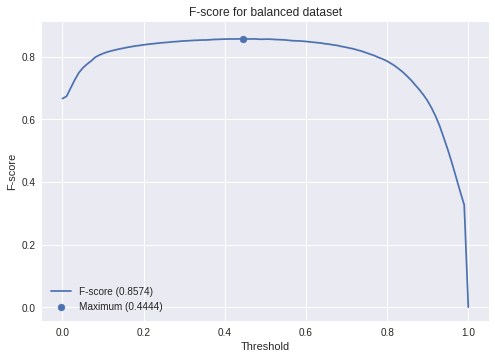

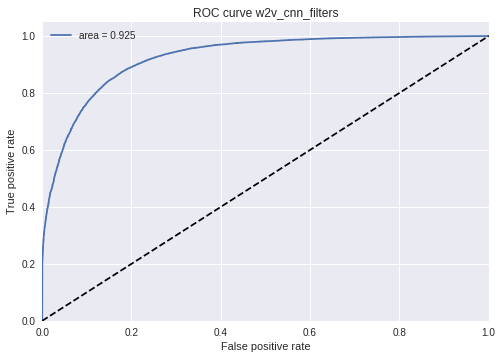

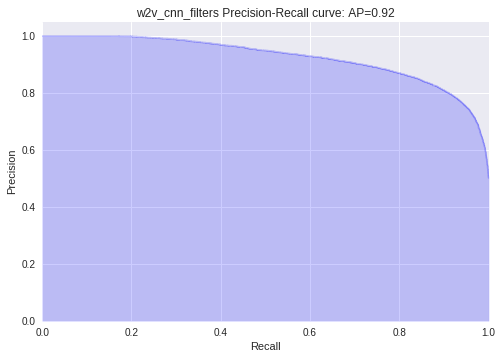

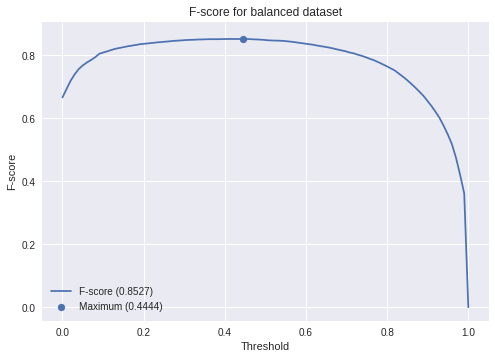

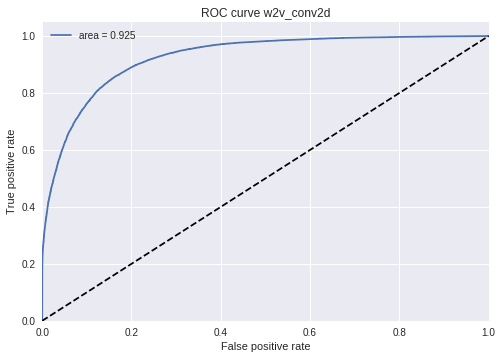

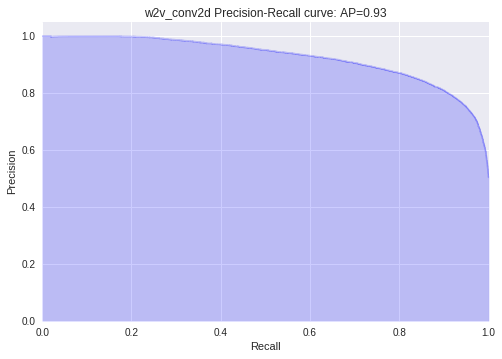

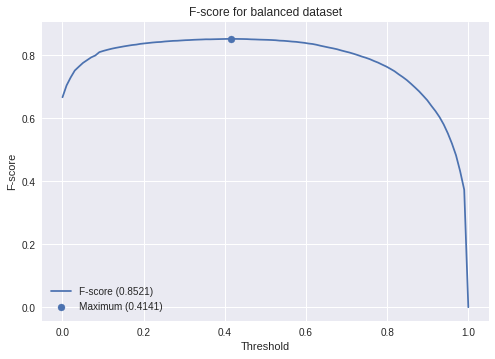

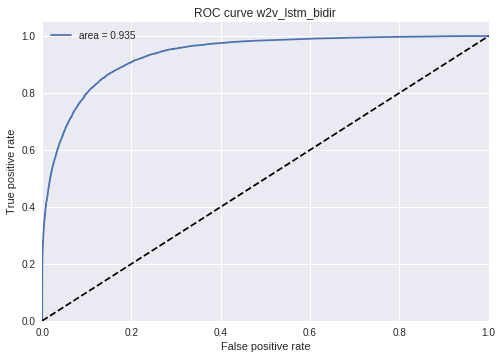

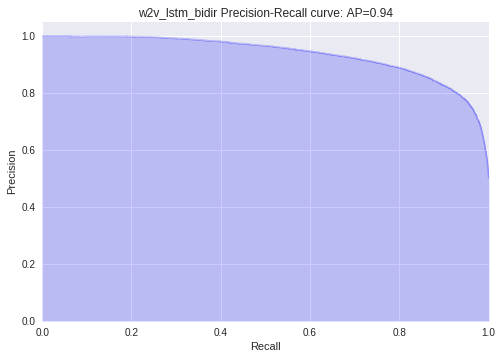

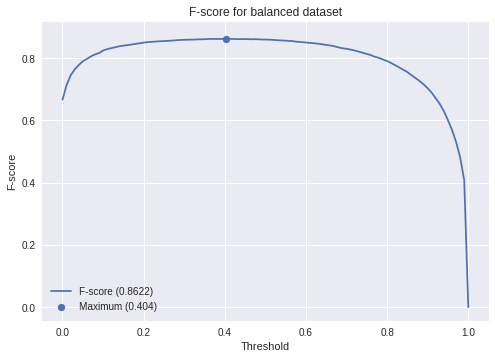

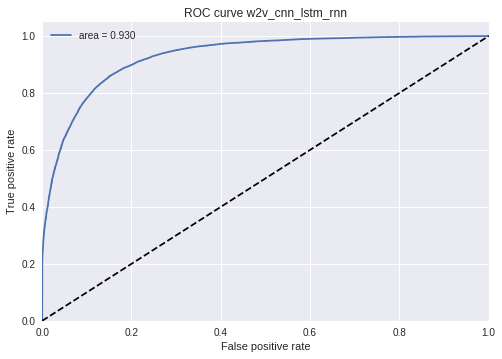

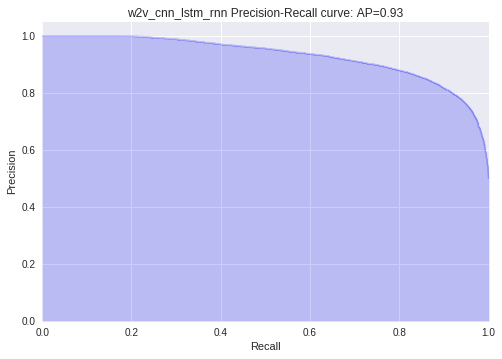

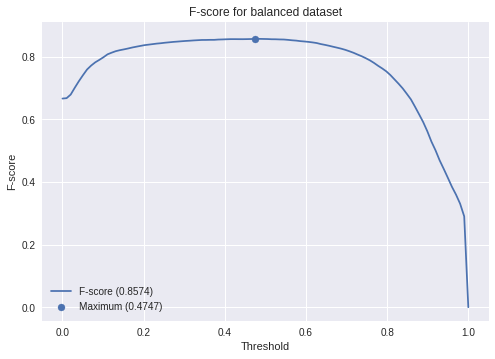

0.4747474747474748

In [0]:
# Оценка точности моделей
score_model(model1) #conv1d
score_model(model2) #gru
score_model(model3) #cnn
score_model(model4) #cnn_filters2
score_model(model5) #lstm_cnn
score_model(model6) #cnn_filters
score_model(model7) #conv2d
score_model(model8) #lstm_bidir
score_model(model9) #cnn_lstm_rnn

# Рисуем ROC и PR кривые
draw_roc_curve(model1)
draw_prec_recall_curve(model1)
draw_f_curve(model2)
draw_roc_curve(model2)
draw_prec_recall_curve(model2)
draw_f_curve(model2)
draw_roc_curve(model3)
draw_prec_recall_curve(model3)
draw_f_curve(model3)
draw_roc_curve(model4)
draw_prec_recall_curve(model4)
draw_f_curve(model4)
draw_roc_curve(model5)
draw_prec_recall_curve(model5)
draw_f_curve(model5)
draw_roc_curve(model6)
draw_prec_recall_curve(model6)
draw_f_curve(model6)
draw_roc_curve(model7)
draw_prec_recall_curve(model7)
draw_f_curve(model7)
draw_roc_curve(model8)
draw_prec_recall_curve(model8)
draw_f_curve(model8)
draw_roc_curve(model9)
draw_prec_recall_curve(model9)
draw_f_curve(model9)


Normalized confusion matrix
[[0.82586763 0.17413237]
 [0.13036573 0.86963427]]


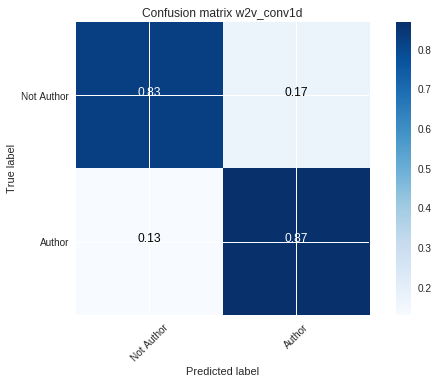

Normalized confusion matrix
[[0.92040731 0.07959269]
 [0.25657434 0.74342566]]


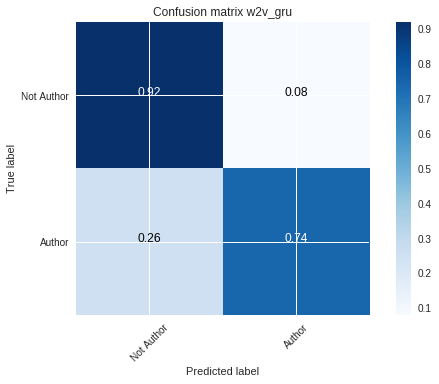

Normalized confusion matrix
[[0.93236489 0.06763511]
 [0.29884628 0.70115372]]


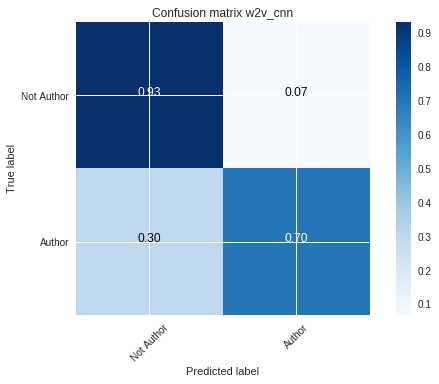

Normalized confusion matrix
[[0.93068336 0.06931664]
 [0.31781027 0.68218973]]


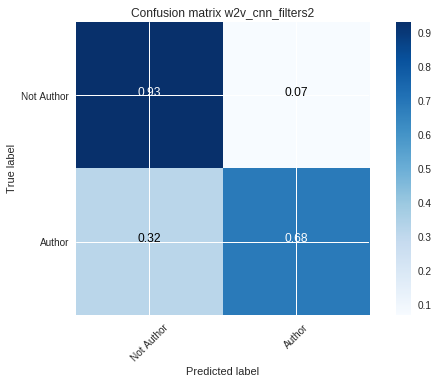

Normalized confusion matrix
[[0.90256434 0.09743566]
 [0.22168247 0.77831753]]


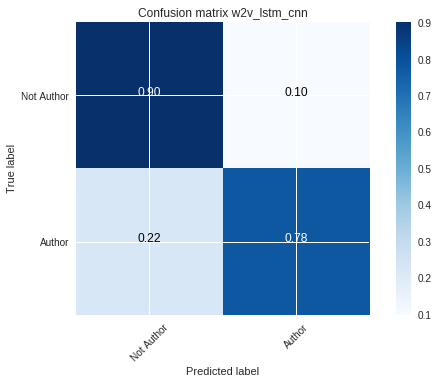

Normalized confusion matrix
[[0.90858985 0.09141015]
 [0.25302443 0.74697557]]


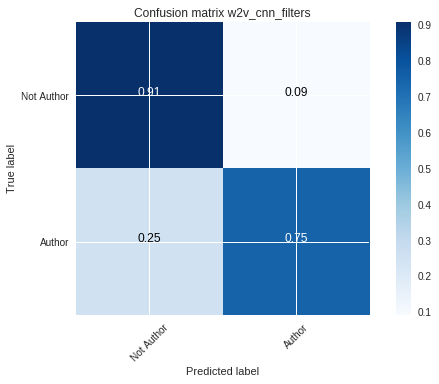

Normalized confusion matrix
[[0.90826288 0.09173712]
 [0.2548928  0.7451072 ]]


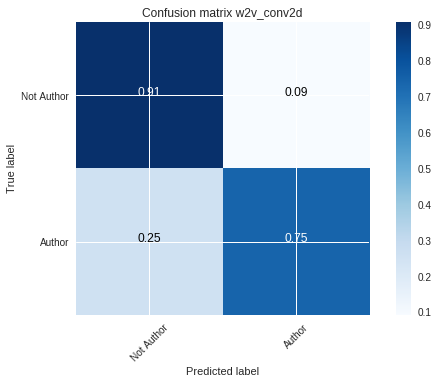

Normalized confusion matrix
[[0.91396142 0.08603858]
 [0.22966977 0.77033023]]


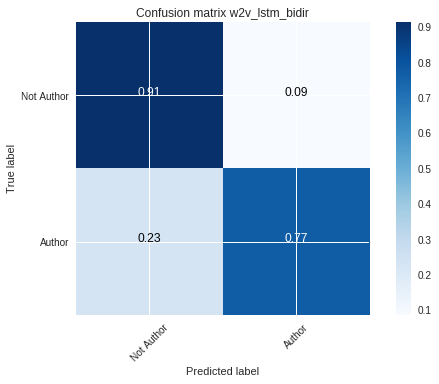

Normalized confusion matrix
[[0.91167266 0.08832734]
 [0.24274838 0.75725162]]


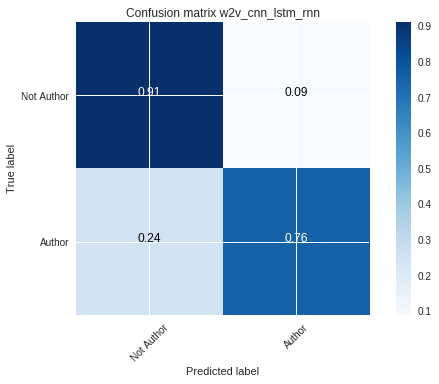

In [0]:
# Оценка качества классификации тестовой или валидационной выборки. Пороговое значение классификации(0 или 1) выставляем как 0.7
labels = ['Not Author', 'Author']
th = 0.7
matrix = build_cf_matrix(model1, 0.4646)
plot_confusion_matrix(matrix, classes=labels, title='Confusion matrix ' + model1.name, normalize=True)
matrix = build_cf_matrix(model2, th)
plot_confusion_matrix(matrix, classes=labels, title='Confusion matrix ' + model2.name, normalize=True)
matrix = build_cf_matrix(model3, th)
plot_confusion_matrix(matrix, classes=labels, title='Confusion matrix ' + model3.name, normalize=True)
matrix = build_cf_matrix(model4, th)
plot_confusion_matrix(matrix, classes=labels, title='Confusion matrix ' + model4.name, normalize=True)
matrix = build_cf_matrix(model5, th)
plot_confusion_matrix(matrix, classes=labels, title='Confusion matrix ' + model5.name, normalize=True)
matrix = build_cf_matrix(model6, th)
plot_confusion_matrix(matrix, classes=labels, title='Confusion matrix ' + model6.name, normalize=True)
matrix = build_cf_matrix(model7, th)
plot_confusion_matrix(matrix, classes=labels, title='Confusion matrix ' + model7.name, normalize=True)
matrix = build_cf_matrix(model8, th)
plot_confusion_matrix(matrix, classes=labels, title='Confusion matrix ' + model8.name, normalize=True)
matrix = build_cf_matrix(model9, th)
plot_confusion_matrix(matrix, classes=labels, title='Confusion matrix ' + model9.name, normalize=True)

Для того чтобы не перебирать весь список моделей полным перебором или выбирать вручную, генерируем набор ансамблей моделей с помощью кодов Грея. Для каждого ансамбля, вычисляем точность и ошибку, выбираем наилучший результат с максимальной точностью и минимальной ошибкой.

In [0]:
# Generate modelset
def gray_code(n):
    def gray_code_recurse (g,n):
        k = len(g)
        if n <= 0:
            return
        else:
            for i in range (k-1, -1, -1):
                char='1' + g[i]
                g.append(char)
            for i in range (k-1, -1, -1):
                g[i]='0' + g[i]
             
            gray_code_recurse (g, n-1)
    
    g = ['0','1']
    gray_code_recurse(g, n-1)
    return g

def gen_list(m):
    out = []
    g = gray_code(len(m))
    for i in range (len(g)):
        mask_str = g[i]
        idx = 0
        v = []
        for c in list(mask_str):
            if c == '1':
               v.append(m[idx])
            idx += 1
        if len(v) > 1:
           out.append(v)
    return out

# cross join ensemble models
models = [model1,model2,model3,model4,model5,model6,model7,model8,model9]
m_list = gen_list(models)
print u"Всего ансамблей для проверки:", len(m_list)
i = 1
s_max = 0 # точнось
e_min = 1 # ошибка
for m_items in m_list:
    print str(i) + ":"
    m_name=' + '.join(str(x.name) for x in m_items)
    #print m_name
    ensemble_model = ensembleModels(m_items, model_input, m_name)
    ensemble_model.compile(loss='binary_crossentropy',optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0), metrics=['accuracy'])
    score = score_model(ensemble_model)
    if score[1] >= s_max and score[0] <= e_min:
      best_models = m_items
      e_min = score[0]
      s_max = score[1]
      with open(work_dir + '/best_model.txt', 'w') as f:
        print >> f, str(i) + ' ' + m_name
        print >> f, score

    print ""
    i += 1

    

Всего ансамблей для проверки: 4
1:
w2v_lstm_cnn + w2v_lstm_bidir
Ошибка теста: 0.335362064718
Оценка точности модели: 85.9288150478

2:
w2v_gru + w2v_lstm_cnn
Ошибка теста: 0.33933019919
Оценка точности модели: 85.4336965111

3:
w2v_gru + w2v_lstm_cnn + w2v_lstm_bidir
Ошибка теста: 0.33760965978
Оценка точности модели: 85.8540801411

4:
w2v_gru + w2v_lstm_bidir
Ошибка теста: 0.329052552527
Оценка точности модели: 85.9685182613



model_big_w2v
Ошибка теста: 0.329052552527
Оценка точности модели: 85.9685182613


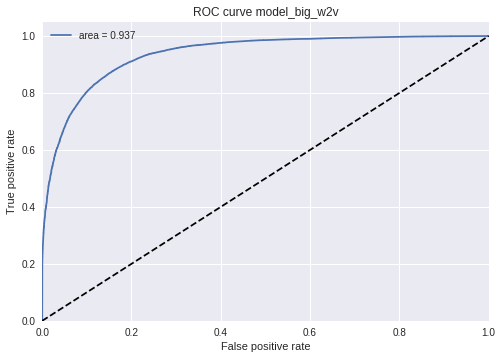

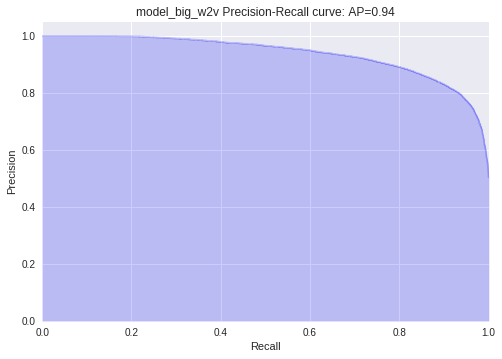

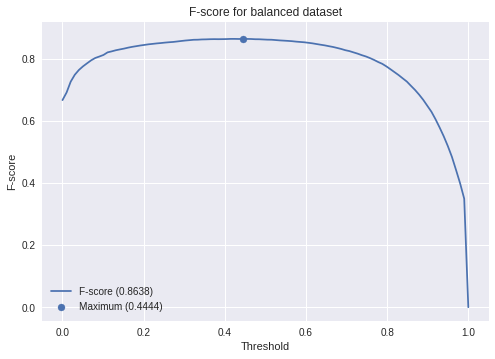

Normalized confusion matrix
[[0.81610538 0.18389462]
 [0.10000467 0.89999533]]


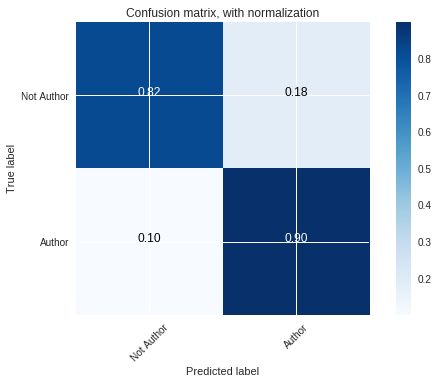

Done


In [0]:
# Компилируем лучший или выбранный нами ансамбль, строим кривые, сохраняем результат
# best_models = [model1,model2]
ensemble_model = ensembleModels(best_models, model_input, name='model_big_w2v')
ensemble_model.compile(loss='binary_crossentropy',optimizer=keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.5), metrics=['accuracy'])
score_model(ensemble_model)
draw_roc_curve(ensemble_model)
draw_prec_recall_curve(ensemble_model)
th = draw_f_curve(ensemble_model)
matrix = build_cf_matrix(ensemble_model, th)
plot_confusion_matrix(matrix, classes=['Not Author', 'Author'], title='Confusion matrix, with normalization', normalize=True)
save_model(ensemble_model)


In [0]:
# для примера: в данном блоке мы разрешаем тренировать Embedding слой, что может дополнительно повысить точность уже натренированной модели.
model2.layers[1].trainable = True #set trainable
model2.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0), metrics=['accuracy', 'mean_squared_error'])
checkpoint = ModelCheckpoint(work_dir + "/weights/" + model2.name  + ".trainable.{epoch:02d}-{loss:.4f}-{acc:.4f}-{val_loss:.4f}-{val_acc:.4f}.hdf5", monitor='val_loss', save_best_only=True, mode='min', period=1)
plot_losses = PlotLossesCallback()
e_stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, restore_best_weights=True)
history_trainable2 = model2.fit(X_train, y_train, batch_size=64, epochs=40, validation_data=(X_test, y_test), callbacks=[checkpoint, e_stop, plot_losses])

models = [model2,model4,model8]
compile_models(models)
ensemble_model = ensembleModels(models, model_input, name='model_big_w2v')
ensemble_model.compile(loss='binary_crossentropy',optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.5), metrics=['accuracy'])
score_model(ensemble_model)
draw_roc_curve(ensemble_model)


In [0]:
# Проверка выбранной модели на заранее сформированной выборке данных
model = ensemble_model

def predict_model(in_text, model):
    #seq = tokenizer.texts_to_sequences([clean_text(in_text)])
    seq = tokenizer.texts_to_sequences([in_text])
    seq = sequence.pad_sequences(seq, maxlen=maxSequenceLength, padding='post')
    return model.predict(np.array(seq))[0][0]
  
with open('/gdrive/dnn_data/comments_test.txt', 'r') as fp:
    line = fp.readline()
    cnt = 1
    while line:
        line = line.strip().decode('utf-8')
        if cnt >=000 and cnt < 3000:
            prob = predict_model(line, model)
            if prob >= 0.5:
                 print line, prob
        line = fp.readline()
        cnt += 1

Dump model data
Draw Layers


/usr/local/lib/python2.7/dist-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


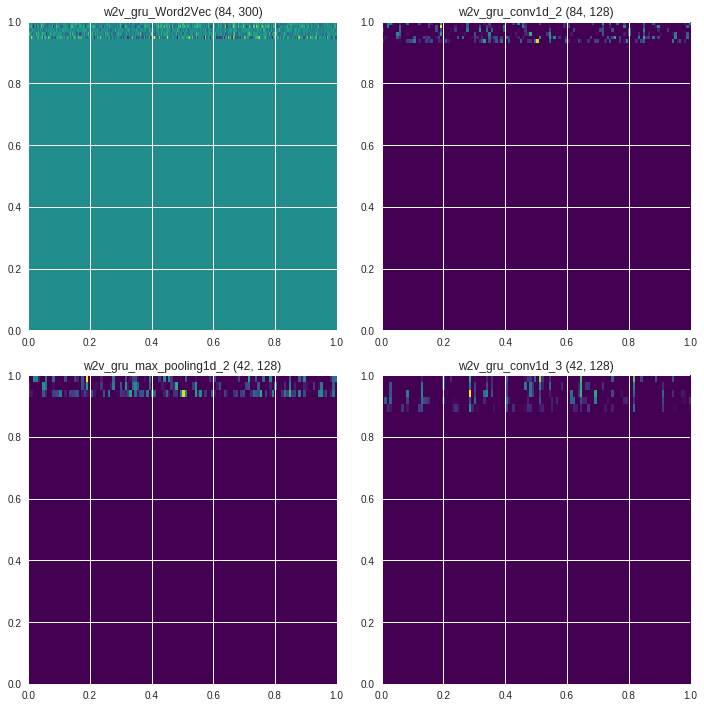

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

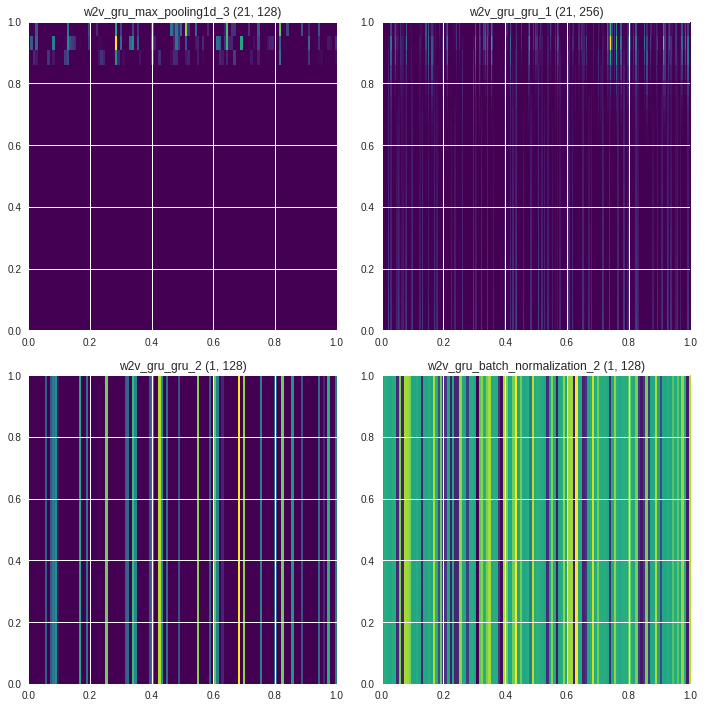

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

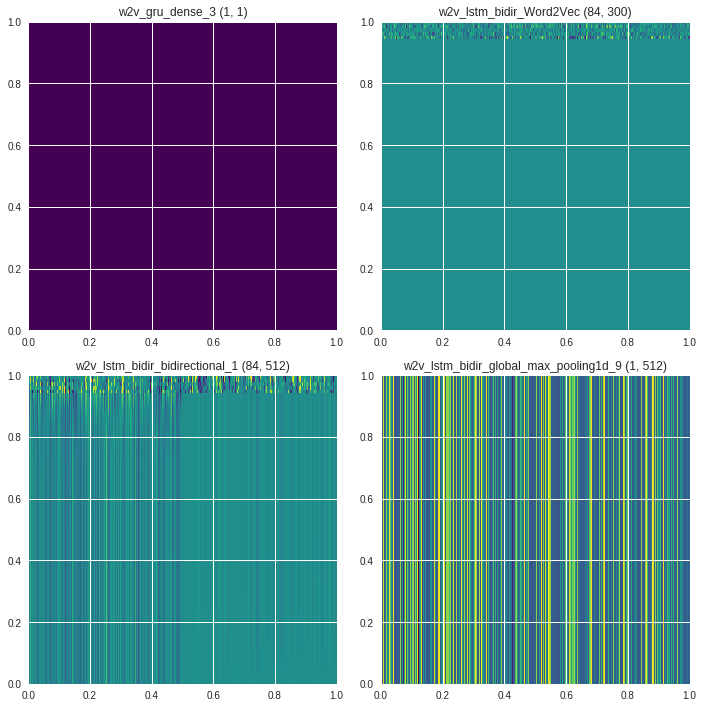

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

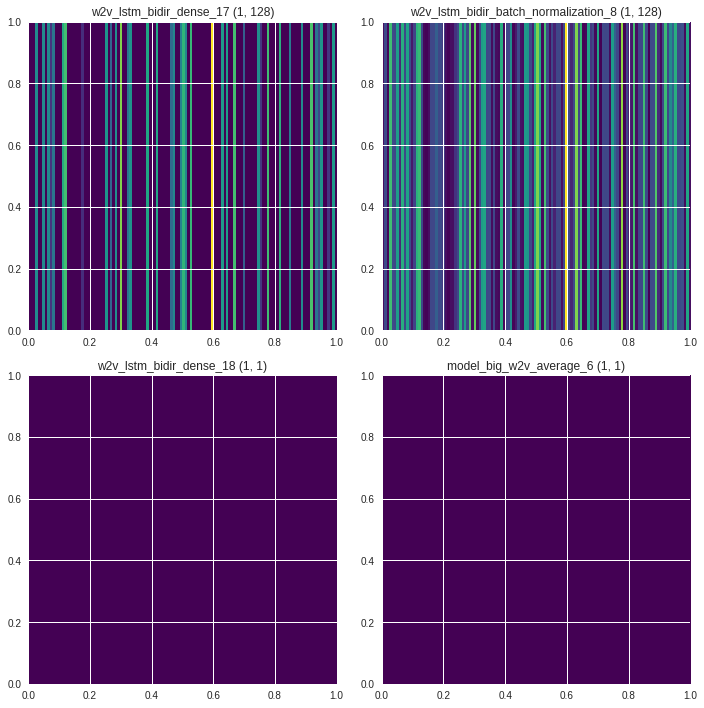

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

In [0]:
def draw_model_insides(i_model, pattern, FOLDER_TO_SAVE, grid_size=(3, 3), limit_size_layer=(2, 2), PLOT_MODEL=False):
    """
    Отображение внутреннего состояния каждого слоя модели на основе определенного переданного шаблона
    :param model: Модель нейроархитектуры keras
    :type model: Sequential
    :param pattern: Входной паттерн, массив данных соответвующий размеру входных слоев
    :type pattern: np.array
    :param FOLDER_TO_SAVE: Папка в которую будет сохраняться результат
    :type FOLDER_TO_SAVE: str
    :param grid_size: Размер отображаемой сетки слоев
    :type grid_size: tuple
    :param limit_size_layer: Минимальный размер для отображения слоя
    :type limit_size_layer: tuple
    :param PLOT_MODEL: Выполнить построение модели
    :type PLOT_MODEL: PLOT_MODEL
    """
    ###
    if not os.path.exists(work_dir + "/PLOT_MODEL_INSIDE"):
      os.makedirs(work_dir + "/PLOT_MODEL_INSIDE")
      
    SAVE_AR_LIST = []
    def dump_layers (model, offset = 0):
        for num_layer in range(1, len(model.layers)):
            # print model.layers[num_layer].name, offset
            if type(model.layers[num_layer]) == keras.engine.training.Model:
                offset += 100
                dump_layers(model.layers[num_layer], offset)

            # исключаем слои не несущие данных
            elif (type(model.layers[num_layer]) != keras.layers.core.Reshape and 
                  type(model.layers[num_layer]) != keras.layers.core.SpatialDropout1D and 
                  type(model.layers[num_layer]) != keras.layers.core.Dropout
                ):
                LO = model.layers[num_layer].output
                _model = Model(inputs=model.inputs, outputs=LO)
                # print model.layers[num_layer].name, _model.output_shape
                # для разных размерностей нужны разные входные данные при отображении
                if (
                    len(_model.output_shape) >= 3 and
                    _model.output_shape[1] > limit_size_layer[0] and
                    _model.output_shape[2] > limit_size_layer[1]
                ):
                    _output = _model.predict(np.array([pattern]))[0]
                    SAVE_AR_LIST.append(
                    [
                        num_layer,
                        model.name + "_" + model.layers[num_layer].name,
                        _output.tolist(),
                        len(_model.output_shape)
                    ]
                    )
                elif len(_model.output_shape) == 2:
                    _output = _model.predict(np.array([pattern]))[0]
                    SAVE_AR_LIST.append(
                    [
                        num_layer,
                        model.name + "_" + model.layers[num_layer].name,
                        _output.tolist(),
                        len(_model.output_shape)
                    ]
                    )
    
    print "Dump model data"
    dump_layers (i_model)
    print "Draw Layers"
    
    PIC_NUM = 0
    while len(SAVE_AR_LIST) > 0:
        fig, axs = plt.subplots(nrows=grid_size[0], ncols=grid_size[1], figsize=(10, 10), tight_layout=True)
        xmin, xmax = plt.xlim()
        ymin, ymax = plt.ylim()
        for ax in axs.flat:
            [num_layer, layer_name, ar, shape] = SAVE_AR_LIST.pop(0)
            # print layer_name
            if shape == 3:
               ar = np.array(ar)
            else:
               ar = np.array([ar])
            plt.figure()
            ax.imshow(ar, cmap='viridis', extent=(xmin, xmax, ymin, ymax))
            ax.set_title(layer_name + " " + str(ar.shape))
            if len(SAVE_AR_LIST) == 0:
                break
        #plt.show()
        plt.savefig(os.path.join(FOLDER_TO_SAVE, str(PIC_NUM) + '.png'), fmt='png')
        plt.show()
        plt.close(fig)        
        PIC_NUM += 1
    ###
    if PLOT_MODEL:
        from keras.utils.vis_utils import plot_model
        plot_model(
            model=i_model,
            to_file=os.path.join(FOLDER_TO_SAVE, i_model.name + " neural network architecture.png"),
            show_shapes=True,
            show_layer_names=True,
        )

pattern = X_test[24433]
# print sequence_to_text(pattern)

draw_model_insides(ensemble_model, pattern = pattern, FOLDER_TO_SAVE = work_dir + "/PLOT_MODEL_INSIDE", PLOT_MODEL=True, grid_size=(2, 2))